In [18]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time
import copy


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [19]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [20]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [21]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [22]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

with open('model_info.json') as a:
    model_info = json.load(a)
    
for key, value in model_info.items():
    model_info[key]['round'] = 0
    model_info[key]['score'] = 0
    model_info[key]['used_index'] = []
    model_info[key]['avg_mean'] = 0
    model_info[key]['avg_std'] = 0
    model_info[key]['mean'] = 0
    model_info[key]['std'] = 0
    
    print(f'Key: {key}, value: {value}')
    print()
    
print('Keys')

#makes a copy for ubc algorithem wont get disurbed by old values
model_info_ubc1 = copy.deepcopy(model_info)

There are 66 labels in the config file
2000
2000
Key: u-net_1585114900, value: {'created': 1585114900, 'training_time': 0, 'data_amount': 140, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.17, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': [], 'avg_mean': 0, 'avg_std': 0, 'mean': 0, 'std': 0}

Key: u-net_1585115750, value: {'created': 1585115750, 'training_time': 0, 'data_amount': 144, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'sigmoid', 'dropout': 0.13, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': [], 'avg_mean': 0, 'avg_std': 0, 'mean': 0, 'std': 0}

Key: u-net_1585116680, value: {'created': 1585116680, 'training_time': 0, 'data_amount': 117, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.48, 'optimizer': 'A

In [23]:
'''
y: prediction target (solution)
y_hat: prediction
returns: predictions in percentage
'''
def pixel_score(y, y_hat):
    
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    num_correct = y_hat * y
    width, height, _ = num_correct.shape
    max_score = width * height
    score = num_correct.sum()
    return score/max_score

def iou_score(y, y_hat):
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    height, width, classes = y_hat.shape
    
    score = 0
    
    for i in range(classes):
        y_class = y[:, : , i]
        y_hat_class = y_hat[:, :, i]
                
        true_positiv = y_hat_class * y_class
        true_positiv = true_positiv.sum()
        #print(f'True positive {true_positiv}')
        
        false_pos = np.logical_and(y_hat_class == 1, y_class == 0)
        false_pos = false_pos.sum()
        #print(f'false positive {false_pos}')
        
        false_neg = np.logical_and(y_hat_class == 0, y_class == 1)
        false_neg = false_neg.sum()
        #print(f'false negative: {false_neg}')
        
        total = true_positiv + false_neg + false_pos
        
        if total != 0:
            score += true_positiv / total
        #print(f'score: {score}')
        
        
    return score / classes

(480, 640, 13)


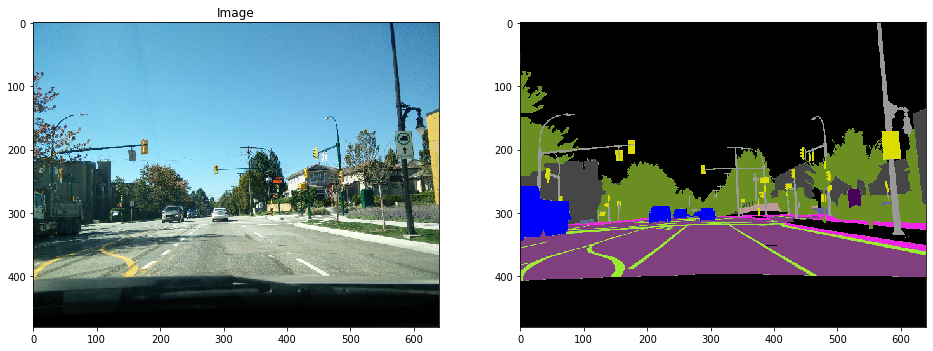

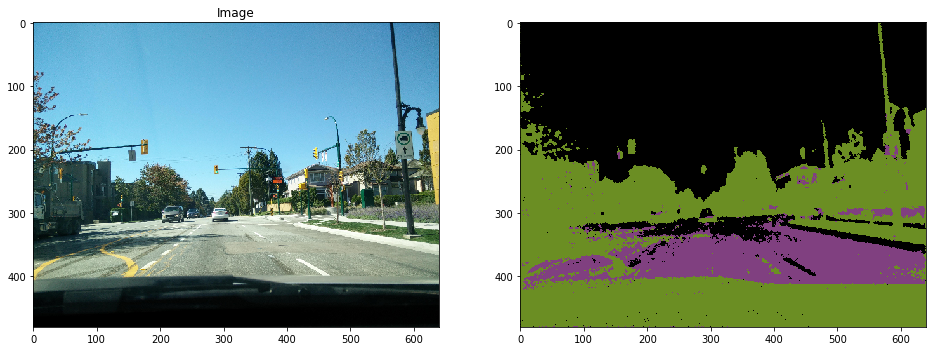

In [24]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
model = load_model(f'seg_models/u-net_1585114900.h5')

img_predicted = model.predict(imges)[0]
target = maskes_to_labels(labels[0]).astype(np.uint8)


print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(imges[0], target, 'Image', 'CityScape labels')
compare_img(imges[0], y_train_label, 'Image', 'CityScape labels')




In [25]:
pixel_score(y=labels[0], y_hat=img_predicted)


0.61962890625

In [26]:


#calculate old score with new
def calculate_score(rounds, score, old_score):
    return old_score * ((rounds-1)/rounds) + score *(1/rounds)


#output: score of model, mean and std
def try_model(key, imgs, labels, model_info, round_nr, lower_bound=True):
    old_score = model_info[key]['score']
    model_info[key]['round'] += 1
    rounds = model_info[key]['round']
    
    model = load_model(f'seg_models/{key}.h5')
    y_hat, mean, std = predictions_and_uncetrenty(model, 5, imgs)
    
    #make mean and std single values
    mean = mean.mean()
    std = std.mean()
    
    #print(y_hat.shape)
    score_p = pixel_score(labels[0], y_hat)
    score_iou = iou_score(labels[0], y_hat)
    
    #change from only using mean to lover bound of derivation
    if lower_bound:
        mean_score = calculate_score(rounds, mean - std, old_score)
    else: 
        mean_score = calculate_score(rounds, mean, old_score)
    
    model_info[key]['score'] = mean_score
    model_info[key]['used_index'].append(round_nr)
    model_info[key]['mean'] = mean
    model_info[key]['avg_mean'] = calculate_score(rounds, mean, model_info[key]['avg_mean'])
    model_info[key]['std'] = std
    model_info[key]['avg_std'] = calculate_score(rounds, std, model_info[key]['avg_std'])
   
    return score_p, score_iou, mean, std


## Policy gradient model


## Run policy gradinet



In [27]:
#tar in state og retunere action

'''
If dropout is 8, 16, 16, 8 learing rate with -2 works, value function have learning rate -3

My problem is exploding gradient 

TODO:
https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/


'''

class policy_model:
    #input (state, state, state, state, action)
    def __init__(self):
        ACTI = 'relu' #, may solve problem, next time you get NaN, selu
        reg = l2(l=0.1)
        inputes = Input(shape=(8,))
        actions_true = Input(shape=[1], name='actions_true')
        advantages = Input(shape=[1], name='advantages')
        _ = Dense(128, activation=ACTI)(inputes) # 8 #, kernel_regularizer=reg
        #_ = Dense(64, activation=ACTI)(_) # 16
        #_ = Dropout(0.2)(_)
        #_ = Dense(32, activation=ACTI)(_) # 16
        #_ = Dropout(0.1)(_)
        #_ = Dense(32, activation=ACTI)(_) #, kernel_regularizer=reg
        out_1 = Dense(2, activation='softmax')(_)

        
        #@tf.function
        def custom_loss_old(y_true, y_pred, adv):
            #out = K.clip(y_pred, 1e-8, 1-1e-8)
            out = y_pred
            log_lik = y_true*K.log(out)
            
            #try - before log_like?
            return K.sum(log_lik*adv)
        
        def custom_loss(y_true, y_pred, adv):

            log_lik =  K.log(y_true * (y_true- y_pred) + (1 - y_true) * (y_true + y_pred))
            return 1 / (-K.mean(log_lik * adv, keepdims=True))



        self.policy = Model(inputs=[inputes, actions_true, advantages], outputs=[out_1])
        self.policy.add_loss(custom_loss(actions_true, out_1, advantages))
        self.policy.compile(optimizer=Adam(lr=1e-3)) # -3, -2 give NaN if value is -4 , clipnorm=0.2
        self.prediction = Model(inputs=inputes, outputs=[out_1])

    #trro vi bruke monte carlo, kjor en heil episode foor trening
    def partial_fit(self, x):
        return self.policy.train_on_batch(x)

    def partial_fit_two(self, x, y, adv):
        adv = np.array(adv)
        return self.policy.train_on_batch([x], y, sample_weight=adv)

    def predict(self, x):
        #print(f'x shape: {x.shape}')
        return self.prediction.predict(x=x)[0] #Why only take firse of 8 output :P 

    
    
class value_model:

    def __init__(self):
        ACTI = 'relu'
        inputes = Input(shape=(8,)) #dtype=float64
        _ = Dense(64, activation=ACTI)(inputes)
        #_ = Dense(16, activation=ACTI)(_)
        #_ = Dropout(0.2)(_)
        _ = Dense(64, activation=ACTI)(_)
        #_ = Dropout(0.2)(_)
        #_ = Dense(16, activation=ACTI)(_)
        out_1 = Dense(1)(_)
        #sgd = SGD(lr=1e-3) #5
        adam = Adam(lr=1e-2) # -3 workes

        self.model = Model(inputs=[inputes], outputs=[out_1])
        self.model.compile(optimizer=adam, loss='mean_squared_error') #mean_squared_error, mean_absolute_error
        #self.model.compile(optimizer=sgd, loss=custom_loss)

    def partial_fit(self, x, y):
        x = np.array(x)
        return self.model.train_on_batch(x, y)


    def predict(self, x):
        return self.model.predict(x)[0]
    
def play_one_episode():
    pass


# 
def play_one_episode(hist_key, data_generator, model_info, value_fuction, policy_model, gamma, episode ,batch_size):
    
    observations = []
    rewards = []
    actions = []
    
    pixel_scores_l = []
    iou_scores = []
    mean_scores = []
    std_scores = []
    
    
    
    total_reward = 0
    
    #model_swich_keys = random.sample(model_info.keys(), 1)
    picked_key = hist_key#model_swich_keys[0]
    picked_value = model_info[hist_key]
    #print(f'picked_key: {picked_key}')
    
    key_list = list(model_info.keys())
    
    #First pick models (policy)
    for i in range(batch_size):
        
        #get new data set 
        img, label = next(data_generator)
        
        
        key_index = 0
        round_nr = episode + i
      
        if len(key_list) <= round_nr:
            key_index = (round_nr) - len(key_list) * ((round_nr) // len(key_list))
        else:
            key_index = round_nr
            
        try:
            test_key = key_list[key_index]#random.sample(model_info.keys(), 1)[0]
        except IndexError as error:
            print(f'ERROR: episode: {episode}, i: {i}, keyindex: {key_index}, first condition: {(len(key_list) <= episode + i)}')
            print(f'len key_list: {len(key_list)}, num times: {(len(key_list) // (round_nr))}')
        #print(f'test key: {test_key}')
        
        
        model_states = [picked_value['mean'], picked_value['std'], picked_value['avg_mean'], picked_value['avg_std'], model_info[test_key]['mean'], model_info[test_key]['std'], model_info[test_key]['avg_mean'] , model_info[test_key]['avg_std']]
        
        
        #print(f'model state: {model_states.shape}')
        action_prob = policy_model.predict(np.array([model_states]))

        #print(f'action prob: {action_prob}')
        #try:
        action = np.random.choice([True, False], p=action_prob)
        #except:
            #print('------------ Error -------------')
            #print(f'action prob: {action_prob}')
            #print()
            #action = True
        
        if action:
            picked_key = test_key
            picked_value = model_info[test_key]
            actions.append(np.array([1]))
        else:
            actions.append(np.array([0]))
    

    
        #second use picked model to to action and reward 
        score_pixel, score_iou,  mean, std = try_model(picked_key, img, label, model_info, round_nr)
        
        pixel_scores_l.append(score_pixel)
        iou_scores.append(score_iou)
        mean_scores.append(mean)
        std_scores.append(std)
        
        given_reward = 0
        #this need to change to mean, we wont have IoU in real scenario
        reward = mean - std
        
        '''
        if reward < 0.1:
            given_reward = 0
        elif reward < 0.15:
            given_reward = 1
        elif reward < 0.2:
            given_reward = 2
        elif reward < 0.25:
            given_reward = 4
        else:
            given_reward = 5
        '''
        #print(reward)
        given_reward += (reward**3 * 13) # *10 
        #print(given_reward)
        #if picked_value['mean'] == picked_value['std'] == picked_value['avg_mean'] == picked_value['avg_std'] == 0:
        #    given_reward *= 1.2
        
        rewards.append(given_reward)
        total_reward += given_reward
        observations.append(model_states)
    
    
    #print(model_states)
    #Thired train model :)
    actions = np.array(actions, dtype=np.int8)
    observations = np.array(observations)
    
    returns = []
    advateges = []
    g_sum = 0
    for s, r in zip(reversed(observations), reversed(rewards)):
        returns.append(g_sum)
        adv = g_sum - value_fuction.predict(np.array([s]))
        advateges.append(adv)
        
        g_sum = r + g_sum * gamma
        
    returns.reverse()
    advateges.reverse()
    advateges = np.array(advateges)    
    
    
    
    
    obs = np.array(observations)

    #print(f'obs: {obs}')
    #print(f'actions: {actions}')
    #print(f'adv: {advateges}')
    #print(f'returns: {returns}')
    value_loss = value_fuction.partial_fit(obs, returns)
    policy_loss = policy_model.partial_fit([obs, actions, advateges])
    
    
    #policy_loss = policy_model.partial_fit_two(observations, action_hot_encoded, advateges)
    return picked_key, total_reward, policy_loss, value_loss, pixel_scores_l, iou_scores, mean_scores, std_scores
    
    #return actions
        
        
        
        #
        
        
        
#value_func = value_model()
#policy_model = policy_model()

#imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
#print(play_one_episode(imges, labels, model_info, value_func, policy_model, 0.99, 1, 2, 1))


In [28]:
TEST_ROUNDS = 10
REDUCED_LIST = True
gamma = 1
value_func = value_model()
policy_mod = policy_model()


num_models = len(list(model_info.keys()))
index_list = range(0, len(img_val_list))
num_trials = len(index_list) // TEST_ROUNDS

#if REDUCED_LIST:
#    key_list_remove = list(model_info.keys())[100:]
#    for key in key_list_remove:
#        del model_info[key]
#        key_list_remove = list(model_info.keys())

gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)

policy_loss_list = []
value_loss_list = []
pixel_score_list = []
iou_score_list = []
mean_list = []
std_list = []
total_reward = []
key_list = list(model_info.keys())
hist_key = random.sample(key_list, 1)[0]

# run bandit thought validation
for i in range(0, len(index_list), TEST_ROUNDS):
    
    # DET UNDER SKAL BYTTES 
    
    new_hist_key, reward, policy_loss, value_loss, pixel_s, iou_s, mean, std = play_one_episode(hist_key, gen, model_info, value_func, policy_mod, gamma, i,TEST_ROUNDS)
    hist_key = new_hist_key 
    policy_loss_list.append(policy_loss)
    value_loss_list.append(value_loss)
    pixel_score_list += pixel_s
    iou_score_list += iou_s
    mean_list += mean
    std_list += std
    total_reward.append(reward)
    # Det OVER SKAL BYTTES
    
    

    K.clear_session()
    #scores.append(new_score)
    #iou_scores.append(score_iou)
    #score_counter.append(new_score)
    
    #means.append(mean)
    #epsilon *= gamma
    PRINT_STEP  = 10 // TEST_ROUNDS

    
    #if i % PRINT_STEP == 0 and i != 0:
    print()
    print('-------------------------- NEW ROUND -----------------------------')
    print(f'round: {i} of {len(index_list)}')
    print(f'policy loss: {np.array(policy_loss_list[-PRINT_STEP:]).mean()}, value loss: {np.array(value_loss_list[-PRINT_STEP:]).mean()}, reward: {np.array(total_reward[-PRINT_STEP:]).mean()}')
    print(f'IoU score: {np.array(iou_s).mean()}, pixel_score: {np.array(pixel_s).mean()}, Mean: {np.array(mean).mean()}, Std: {np.array(std).mean()}')
    print()
    score_counter = []
        
        



-------------------------- NEW ROUND -----------------------------
round: 0 of 2000
policy loss: 0.12136472016572952, value loss: 209.1962890625, reward: 21.23597921349323
IoU score: 0.10875166488719938, pixel_score: 0.5561845703125, Mean: 0.510554850101471, Std: 0.031710512936115265


-------------------------- NEW ROUND -----------------------------
round: 10 of 2000
policy loss: 0.14933684468269348, value loss: 114.74107360839844, reward: 15.036821219219892
IoU score: 0.09856593844317116, pixel_score: 0.6041246744791666, Mean: 0.4959881901741028, Std: 0.04240257665514946


-------------------------- NEW ROUND -----------------------------
round: 20 of 2000
policy loss: 0.4164060056209564, value loss: 16.95854377746582, reward: 11.150655688748454
IoU score: 0.08257271940982838, pixel_score: 0.40077962239583337, Mean: 0.47890767455101013, Std: 0.06815692037343979


-------------------------- NEW ROUND -----------------------------
round: 30 of 2000
policy loss: 0.29808691143989563, v


-------------------------- NEW ROUND -----------------------------
round: 280 of 2000
policy loss: -0.3640981912612915, value loss: 28.084604263305664, reward: 8.315767102821022
IoU score: 0.09477859187461501, pixel_score: 0.4888671875, Mean: 0.44395431876182556, Std: 0.06980010867118835


-------------------------- NEW ROUND -----------------------------
round: 290 of 2000
policy loss: 5.977752208709717, value loss: 54.53703689575195, reward: 16.699962244454955
IoU score: 0.09678401722720228, pixel_score: 0.43846744791666675, Mean: 0.5079249143600464, Std: 0.05541054531931877


-------------------------- NEW ROUND -----------------------------
round: 300 of 2000
policy loss: -0.7221461534500122, value loss: 27.523052215576172, reward: 15.562768801168025
IoU score: 0.07249972693698664, pixel_score: 0.49362630208333336, Mean: 0.5341678857803345, Std: 0.05997629836201668


-------------------------- NEW ROUND -----------------------------
round: 310 of 2000
policy loss: -1.5703192949295


-------------------------- NEW ROUND -----------------------------
round: 560 of 2000
policy loss: -0.6760689616203308, value loss: 52.951133728027344, reward: 23.565083256375885
IoU score: 0.1472947639772199, pixel_score: 0.5816337890625, Mean: 0.5803767442703247, Std: 0.07388514280319214


-------------------------- NEW ROUND -----------------------------
round: 570 of 2000
policy loss: -0.8260920643806458, value loss: 55.922080993652344, reward: 19.328179391382655
IoU score: 0.09440125371256292, pixel_score: 0.5180615234375, Mean: 0.5715085864067078, Std: 0.06584767252206802


-------------------------- NEW ROUND -----------------------------
round: 580 of 2000
policy loss: -0.19196809828281403, value loss: 74.54136657714844, reward: 13.34123766649171
IoU score: 0.08301313226235355, pixel_score: 0.460412109375, Mean: 0.5154664516448975, Std: 0.08997742831707001


-------------------------- NEW ROUND -----------------------------
round: 590 of 2000
policy loss: -1.0371592044830322, 


-------------------------- NEW ROUND -----------------------------
round: 840 of 2000
policy loss: -0.3787060081958771, value loss: 15.520849227905273, reward: 5.04980748520208
IoU score: 0.06358451507081361, pixel_score: 0.362853515625, Mean: 0.39816799759864807, Std: 0.07275162637233734


-------------------------- NEW ROUND -----------------------------
round: 850 of 2000
policy loss: -1.8609082698822021, value loss: 21.861343383789062, reward: 17.93163903706452
IoU score: 0.09935810440417078, pixel_score: 0.5803577473958333, Mean: 0.5554366111755371, Std: 0.08361923694610596


-------------------------- NEW ROUND -----------------------------
round: 860 of 2000
policy loss: 0.20657581090927124, value loss: 143.55935668945312, reward: 28.667351494573865
IoU score: 0.16489942324117285, pixel_score: 0.6371005859375, Mean: 0.6197802424430847, Std: 0.061254680156707764


-------------------------- NEW ROUND -----------------------------
round: 870 of 2000
policy loss: -0.30714258551597


-------------------------- NEW ROUND -----------------------------
round: 1120 of 2000
policy loss: -3.1660637855529785, value loss: 20.42320442199707, reward: 19.92854496706866
IoU score: 0.09115042177929997, pixel_score: 0.5542965494791666, Mean: 0.584455668926239, Std: 0.08672460168600082


-------------------------- NEW ROUND -----------------------------
round: 1130 of 2000
policy loss: -9.249744415283203, value loss: 24.080013275146484, reward: 16.46738934397531
IoU score: 0.10363378085357552, pixel_score: 0.5600865885416667, Mean: 0.5669761896133423, Std: 0.08852929621934891


-------------------------- NEW ROUND -----------------------------
round: 1140 of 2000
policy loss: -0.4807819128036499, value loss: 13.602200508117676, reward: 7.886616402804468
IoU score: 0.06599671598692845, pixel_score: 0.4363883463541667, Mean: 0.48173514008522034, Std: 0.10815803706645966


-------------------------- NEW ROUND -----------------------------
round: 1150 of 2000
policy loss: -0.5535489


-------------------------- NEW ROUND -----------------------------
round: 1400 of 2000
policy loss: 0.21380667388439178, value loss: 163.88406372070312, reward: 31.10079390262936
IoU score: 0.12851623774516754, pixel_score: 0.6359091796874999, Mean: 0.6529555320739746, Std: 0.0582113154232502


-------------------------- NEW ROUND -----------------------------
round: 1410 of 2000
policy loss: 0.5192378759384155, value loss: 31.1768856048584, reward: 16.247411641046043
IoU score: 0.08734262373277914, pixel_score: 0.4855286458333333, Mean: 0.5194830894470215, Std: 0.07602725923061371


-------------------------- NEW ROUND -----------------------------
round: 1420 of 2000
policy loss: -7.022063732147217, value loss: 12.325302124023438, reward: 13.720176567637008
IoU score: 0.09137317542440952, pixel_score: 0.49996614583333326, Mean: 0.533810019493103, Std: 0.08236904442310333


-------------------------- NEW ROUND -----------------------------
round: 1430 of 2000
policy loss: -0.64529567


-------------------------- NEW ROUND -----------------------------
round: 1680 of 2000
policy loss: 1.2051784992218018, value loss: 13.722536087036133, reward: 16.333903871079418
IoU score: 0.12011918451472114, pixel_score: 0.5808404947916666, Mean: 0.5175026655197144, Std: 0.07745703309774399


-------------------------- NEW ROUND -----------------------------
round: 1690 of 2000
policy loss: -1.1700587272644043, value loss: 22.144367218017578, reward: 18.34539908926278
IoU score: 0.10651061307907003, pixel_score: 0.5409163411458333, Mean: 0.5156769752502441, Std: 0.03742187097668648


-------------------------- NEW ROUND -----------------------------
round: 1700 of 2000
policy loss: 0.17955581843852997, value loss: 141.9973907470703, reward: 22.472692062030337
IoU score: 0.09966025608887659, pixel_score: 0.5814772135416667, Mean: 0.5170305967330933, Std: 0.04537292569875717


-------------------------- NEW ROUND -----------------------------
round: 1710 of 2000
policy loss: -0.52008


-------------------------- NEW ROUND -----------------------------
round: 1960 of 2000
policy loss: 1.3317948579788208, value loss: 37.412845611572266, reward: 17.24407189983682
IoU score: 0.07638546526316195, pixel_score: 0.4390198567708333, Mean: 0.5189797282218933, Std: 0.06448709964752197


-------------------------- NEW ROUND -----------------------------
round: 1970 of 2000
policy loss: 0.8516668081283569, value loss: 41.20558547973633, reward: 18.791654124040022
IoU score: 0.12200750439059971, pixel_score: 0.5690315755208333, Mean: 0.5512205362319946, Std: 0.05797143653035164


-------------------------- NEW ROUND -----------------------------
round: 1980 of 2000
policy loss: -5.436019420623779, value loss: 20.754947662353516, reward: 15.647711758056042
IoU score: 0.08040110387861335, pixel_score: 0.4660022786458334, Mean: 0.5386183857917786, Std: 0.07230053097009659


-------------------------- NEW ROUND -----------------------------
round: 1990 of 2000
policy loss: -0.9100435

 Avg score pr model: 0.4576838353331378


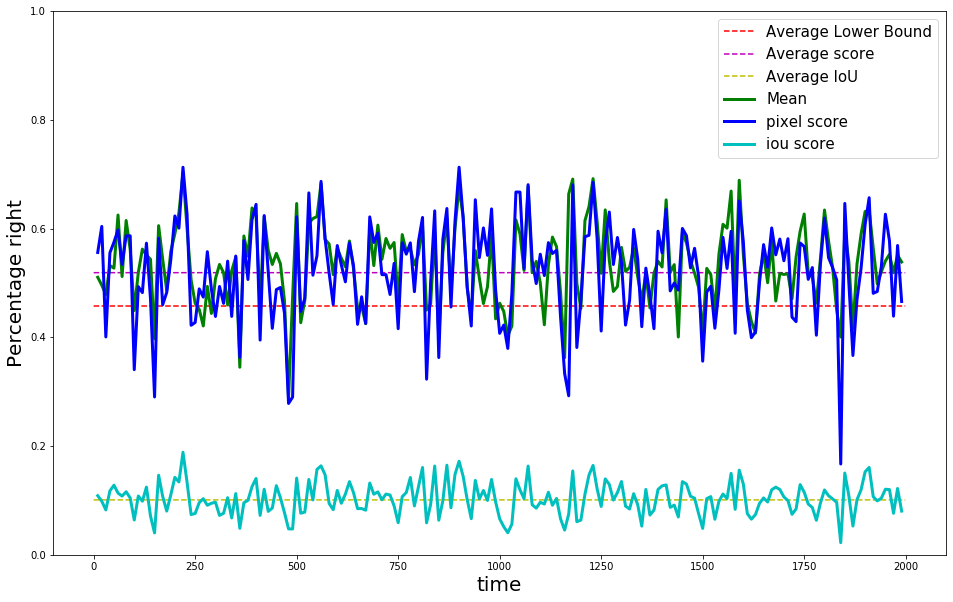

In [29]:

#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses

def score_graph(scores, iou_scores, means, model_info, batch_size, list_length):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    
    
    print(f' Avg score pr model: {model_score_avg}')
    
    avg = np.array([model_score_avg for i in range(list_length)])
    avg_explore = np.array([0.519 for i in range(list_length)]) # 0.5186551321699284
    #avg_iou = np.array([0.0185 for i in range(list_length)]) #0.0185 0.13364625770486935
    avg_iou = np.array([0.101 for i in range(list_length)]) #0.10119017522614594
    
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(avg_iou, 'y--', label='Average IoU')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='pixel score')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='iou score')
    plt.legend(loc='best', fontsize=15)
    plt.show()

score_graph(pixel_score_list, iou_score_list, mean_list, model_info, batch_size=10, list_length=num_trials*TEST_ROUNDS)

In [30]:



for key, value in model_info.items():
    print(f'Key: {key}, score: {value["score"]}, mean: {value["mean"]}, std: {value["std"]}, avg mean: {value["avg_mean"]}, avg std: {value["avg_std"]}, rounds: {value["round"]}, time used: {value["used_index"]}')
    print()

Key: u-net_1585114900, score: 0.550277421871821, mean: 0.7265120148658752, std: 0.03809326887130737, avg mean: 0.600364605585734, avg std: 0.050087183713912964, rounds: 3, time used: [338, 339, 340]

Key: u-net_1585115750, score: 0.32901908031531746, mean: 0.32920950651168823, std: 0.00018989753152709454, avg mean: 0.3292091829436166, avg std: 0.00019010201400046105, rounds: 14, time used: [1, 2, 3, 4, 677, 1015, 1016, 1017, 1018, 1353, 1354, 1355, 1356, 1691]

Key: u-net_1585116680, score: 0.5551183968782425, mean: 0.44364938139915466, std: 0.058766547590494156, avg mean: 0.6096149235963821, avg std: 0.054496536031365395, rounds: 2, time used: [678, 1692]

Key: u-net_1585118770, score: 0.6180173695087433, mean: 0.7268067598342896, std: 0.06063483655452728, avg mean: 0.6878521323204041, avg std: 0.06983474716544152, rounds: 5, time used: [341, 342, 343, 679, 1693]

Key: u-net_1585123137, score: 0.45176343619823456, mean: 0.5254201889038086, std: 0.0358213447034359, avg mean: 0.48730514

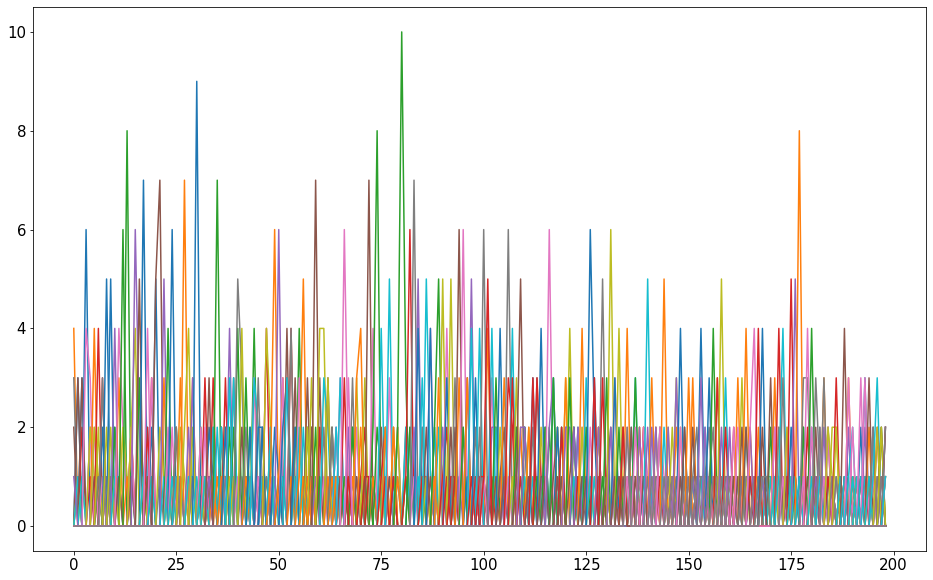

In [31]:
def plot_model_used(model_info, num_models, num_trials, batch_size):
    model_used = np.zeros((num_models, num_trials), dtype=np.uint8)

    #smooth = (len(index_list)+batch_size)//batch_size
    #print(smooth)

    counter = 0
    for key, value in model_info.items():
        #model_used[counter]
        for index in value['used_index']:
            model_used[counter][index] = 1

        counter += 1 

    model_used_smoothe = [] #np.zeros((len(key_list), smooth), dtype=np.uint8)
    counter = 0
    for used in model_used:
        periodic = []
        model_used_smoothe.append([])
        for i in range(len(used)):
            if i % batch_size == 0 and i != 0:
                model_used_smoothe[counter].append(sum(periodic))
                periodic = []
            periodic.append(used[i])
        counter += 1


    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)

    for used_per in model_used_smoothe:
        #print(used_per)
        plt.plot(used_per)
    #print(model_used_smoothe[5])
    #plt.plot(model_used_smoothe[5])
    plt.show()
plot_model_used(model_info, num_models, len(index_list), batch_size=10)

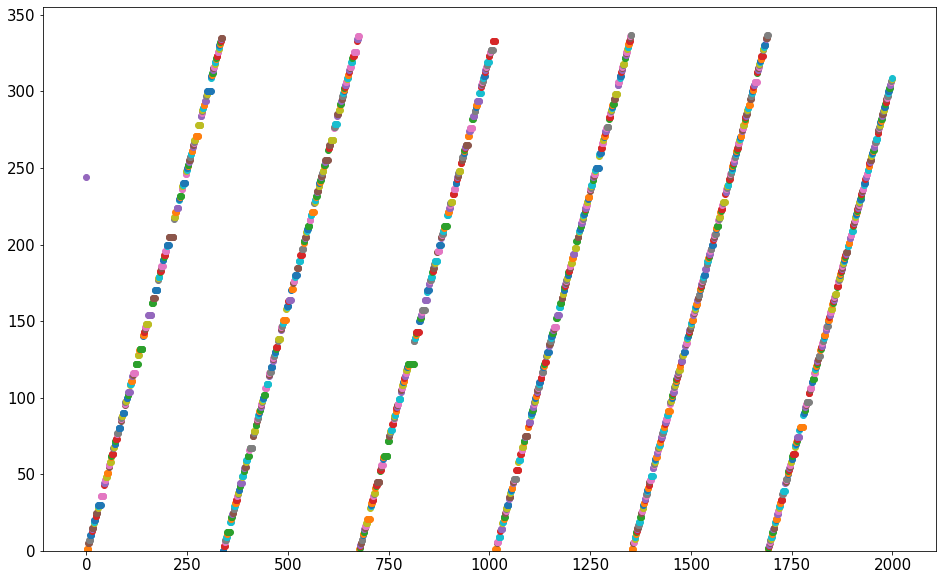

In [32]:

def scatter_model_used(model_info, num_models, num_trials):
    counter = 0
    used_list = []
    
    for _ in range(num_models):
        used_list.append(np.full(num_trials, -10))
    
    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[counter][used] = counter

        counter += 1
        
    counter_list = range(num_trials)
    
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0, int(round(num_models * 1.05)))
    for i in range(num_models):
        plt.scatter(counter_list, used_list[i])
    plt.show()
scatter_model_used(model_info, num_models, len(index_list))

#scatter_model_used(model_info, num_models, num_trials)

In [33]:
print('Average ressults') #0.3, 0.2
print(f'models used: {len(key_list)}')
print(f'Score: {np.array(pixel_score_list).mean()}') #0.6452791124131944, #0.6169490690104167
print(f'Mean: {np.array(mean_list).mean()}') # 0.6408893465995789, #0.6559882760047913
print(f'IoU Score: {np.array(iou_score_list).mean()}') #0.15

Average ressults
models used: 338
Score: 0.5207244905598958
Mean: 0.5336290001869202
IoU Score: 0.10369809885617585


## UCB1

Average ressults UCB 1:
Score: 0.72
Mean: 0.73
Iou: 0.25

In [17]:
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)

scores_ucb1 = []
iou_scores_ucb1 = []
means_ucb1 = []
score_counter_ucb1 = []



def ucb1_score(rounds, model_info, c):
    model_round = model_info['round']
    
    if model_round == 0:
        return np.inf
    #print(f'rounds: {model_info["round"]} ,score: {model_info["score"]} time used: {model_info["used_index"]}')
    explotation = model_info['score']
    explortion = math.sqrt(math.log(rounds)/model_round)
    
    return explotation + c*explortion


# run bandit thought validation
for i in range(len(index_list)):
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)

        
    best_model_key = None
    best_score = -np.inf
    printe_score = True
    
    for key, value in model_info_ubc1.items():
        score = ucb1_score(rounds=i, model_info=value, c=0.05) 
        #save some init time
        if score == np.inf:
            if i > num_models:
                print('FAAAAIL')
            best_model_key = key
            break
            
        if printe_score:
            printe_score = False
        
        if score > best_score:
            best_score = score
            best_model_key = key
            
    
    new_score, score_iou, mean, std = try_model(best_model_key, imgs, labels, model_info_ubc1, i)

    
    #print(f'mean: {mean}, std: {std}')
    

    K.clear_session()
    scores_ucb1.append(new_score)
    score_counter_ucb1.append(new_score)
    means_ucb1.append(mean)
    iou_scores_ucb1.append(score_iou)
    #epsilon *= gamma
    
    if i % 10 == 0:
        printe_score = True
        print(f'round: {i} of {len(index_list)}, score: {sum(score_counter_ucb1)}')
        score_counter_ucb1 = []
        


round: 0 of 2000, score: 0.5678548177083333
round: 10 of 2000, score: 5.74373046875
round: 20 of 2000, score: 6.03541015625
round: 30 of 2000, score: 3.617682291666666
round: 40 of 2000, score: 4.503619791666667
round: 50 of 2000, score: 5.853199869791666
round: 60 of 2000, score: 5.669361979166666
round: 70 of 2000, score: 5.445182291666666
round: 80 of 2000, score: 5.628313802083333
round: 90 of 2000, score: 4.915621744791666
round: 100 of 2000, score: 4.261220703125
round: 110 of 2000, score: 5.000374348958334
round: 120 of 2000, score: 5.924964192708334
round: 130 of 2000, score: 4.515094401041666
round: 140 of 2000, score: 3.7068782552083337
round: 150 of 2000, score: 3.562021484375
round: 160 of 2000, score: 6.400065104166666
round: 170 of 2000, score: 4.705296223958333
round: 180 of 2000, score: 5.249615885416667
round: 190 of 2000, score: 5.55486328125
round: 200 of 2000, score: 5.511487630208333


KeyboardInterrupt: 

In [ ]:
score_graph(scores_ucb1, iou_scores_ucb1, means_ucb1, model_info_ubc1, batch_size=10, list_length=num_trials)

In [ ]:
for key, value in model_info_ubc1.items():
    print(f'Key: {key}, rounds: {value["round"]} ,score: {value["score"]} time used: {value["used_index"]}')
    print()

In [ ]:
plot_model_used(model_info_ubc1, num_models, num_trials, batch_size=10)

In [ ]:
scatter_model_used(model_info_ubc1, num_models, num_trials)

In [ ]:
print('Average ressults')
print(f'Score: {np.array(scores_ucb1).mean()}')
print(f'Mean: {np.array(means_ucb1).mean()}')
print(f'IoU score: {np.array(iou_scores_ucb1).mean()}')

Average ressults UCB 1:
Score: 0.72
Mean: 0.73
Iou: 0.25